In [57]:
# All imported libraries
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
from keras.layers import Dense, Flatten
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
import time
import math

## Loading data
This function loads all data into their own numpy arrays.

In [50]:
# Function that loads all required data in its own np array.
def load_and_preprocess_dataset():
    x_train = []
    y_train = []
    data = os.listdir('CarsSet/DATA/DATA/train')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/train', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_train.append(img)
        else:
            # Load the XML annotation file
            tree = ET.parse(os.path.join('CarsSet/DATA/DATA/train', image))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            bbox = []
            # Extract the xmin, ymin, xmax, and ymax values from the bndbox element
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            # Scale the bounding box coordinates to match the resized image
            height, width, _ = imgShape.shape
            scale_x = 224 / width
            scale_y = 224 / height
            xmin = int(xmin * scale_x)
            ymin = int(ymin * scale_y)
            xmax = int(xmax * scale_x)
            ymax = int(ymax * scale_y)
            bbox.append(xmin)
            bbox.append(ymin)
            bbox.append(xmax)
            bbox.append(ymax)
            y_train.append(bbox)
    
    
    x_val = []
    y_val = []
    data = os.listdir('CarsSet/DATA/DATA/validate')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/validate', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_val.append(img)
        else:
            # Load the XML annotation file
            tree = ET.parse(os.path.join('CarsSet/DATA/DATA/validate', image))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            bbox = []
            # Extract the xmin, ymin, xmax, and ymax values from the bndbox element
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            # Scale the bounding box coordinates to match the resized image
            height, width, _ = imgShape.shape
            scale_x = 224 / width
            scale_y = 224 / height
            xmin = int(xmin * scale_x)
            ymin = int(ymin * scale_y)
            xmax = int(xmax * scale_x)
            ymax = int(ymax * scale_y)
            bbox.append(xmin)
            bbox.append(ymin)
            bbox.append(xmax)
            bbox.append(ymax)
            y_val.append(bbox)


    x_test = []
    y_test = []
    data = os.listdir('CarsSet/DATA/DATA/test')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/test', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_test.append(img)
        else:
            # Load the XML annotation file
            tree = ET.parse(os.path.join('CarsSet/DATA/DATA/test', image))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            bbox = []
            # Extract the xmin, ymin, xmax, and ymax values from the bndbox element
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            # Scale the bounding box coordinates to match the resized image
            height, width, _ = imgShape.shape
            scale_x = 224 / width
            scale_y = 224 / height
            xmin = int(xmin * scale_x)
            ymin = int(ymin * scale_y)
            xmax = int(xmax * scale_x)
            ymax = int(ymax * scale_y)
            bbox.append(xmin)
            bbox.append(ymin)
            bbox.append(xmax)
            bbox.append(ymax)
            y_test.append(bbox)

    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)


In [51]:
# Load and preprocess the dataset
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_and_preprocess_dataset()

## Neural network
In the following code I make a model based on the VGG16 model from Keras. For detecting cars in images, the VGG16 model can be fine-tuned on a dataset of car images, where the last fully connected layer is replaced with a new output layer that predicts the bounding box coordinates of the car in the image. The pre-trained weights of the model can then be fine-tuned on this new task, which allows the model to learn to detect cars in images with high accuracy.

To fine-tune the VGG16 model I dont include the top classification layer and make it myself. 
These lines add a flatten layer and a dense layer on top of the pre-trained VGG16 model. The Flatten layer flattens the output from the previous layer to a 1D tensor. The first Dense layer has 256 units with a ReLU activation function. The final Dense layer has 4 units with a linear activation function.

In [52]:
# Get the input shape from X_train
input_shape = X_train.shape[1:]

# Load VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a flatten layer and a dense layer for classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(4, activation='linear')(x)

# Create a new model with input and output layers, so that only the weights of the new top classification layer will be updated during training.
model = Model(inputs=base_model.input, outputs=output)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Training the Model
The model is being trained below, I am using 10 epochs because it does not find much improvement after that.

In [53]:
# Train the model
hist = model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), batch_size=32)

Epoch 1/10
9/9 [==============================] - 18s 2s/step - loss: 10513.3252 - mean_squared_error: 10513.3252 - val_loss: 2868.7668 - val_mean_squared_error: 2868.7668
Epoch 2/10
9/9 [==============================] - 17s 2s/step - loss: 4543.9951 - mean_squared_error: 4543.9951 - val_loss: 1853.6189 - val_mean_squared_error: 1853.6189
Epoch 3/10
9/9 [==============================] - 16s 2s/step - loss: 2107.0393 - mean_squared_error: 2107.0393 - val_loss: 1247.1993 - val_mean_squared_error: 1247.1993
Epoch 4/10
9/9 [==============================] - 16s 2s/step - loss: 999.4894 - mean_squared_error: 999.4894 - val_loss: 675.7872 - val_mean_squared_error: 675.7872
Epoch 5/10
9/9 [==============================] - 16s 2s/step - loss: 440.1953 - mean_squared_error: 440.1953 - val_loss: 674.5240 - val_mean_squared_error: 674.5240
Epoch 6/10
9/9 [==============================] - 16s 2s/step - loss: 247.4576 - mean_squared_error: 247.4576 - val_loss: 789.3199 - val_mean_squared_error:

## Results training
Below are the results of training the model. As can be seen in the histogram, the algorithm quickly improves in recognizing cars. This is also evident in the orange line, which validates this.

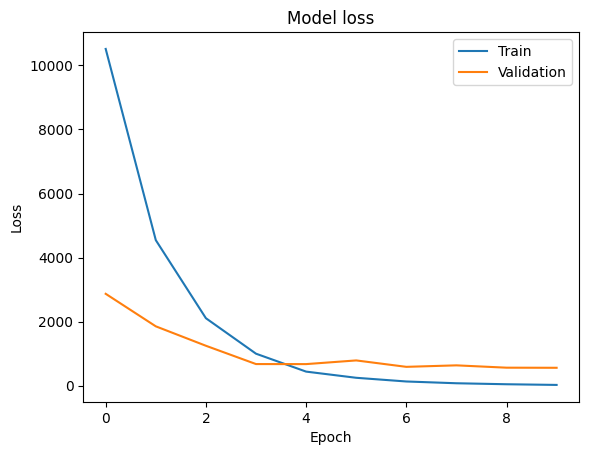

In [54]:
# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Model opslaan

In [55]:
# Save the model
model.save("improved_model.h5")

## Results
As can be seen in the images, my model can usually extract the car from the image. The bounding box is not always perfectly around the car, but it usually identifies the headlights. It sometimes struggles with clouds and mountains, where the model can be completely wrong.

1/1 [==============================] - 0s 101ms/step
0.13056087493896484  seconds to predict bounding box.


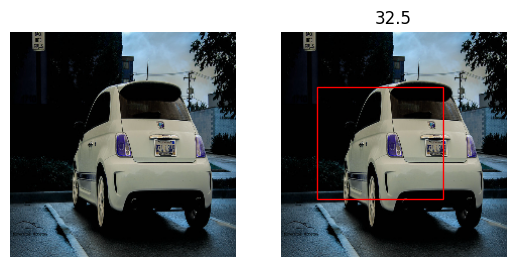

1/1 [==============================] - 0s 103ms/step
0.13081932067871094  seconds to predict bounding box.


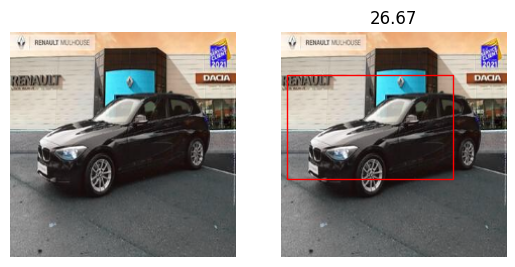

1/1 [==============================] - 0s 115ms/step
0.15004467964172363  seconds to predict bounding box.


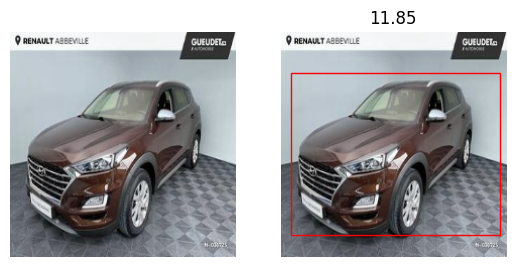

1/1 [==============================] - 0s 97ms/step
0.1242055892944336  seconds to predict bounding box.


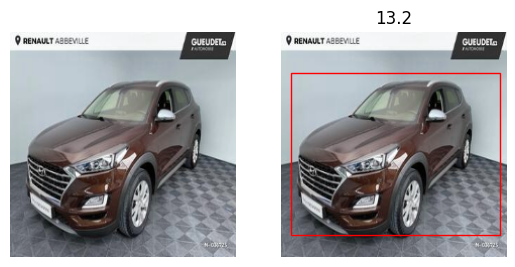

1/1 [==============================] - 0s 102ms/step
0.1335315704345703  seconds to predict bounding box.


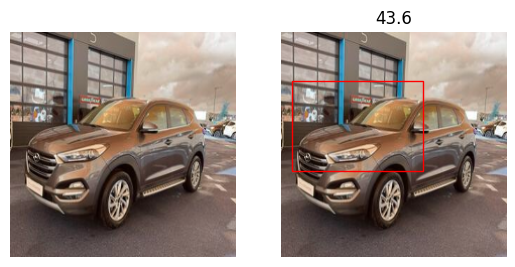

1/1 [==============================] - 0s 97ms/step
0.1269211769104004  seconds to predict bounding box.


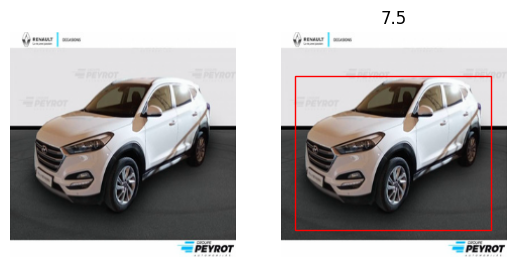

1/1 [==============================] - 0s 100ms/step
0.13011860847473145  seconds to predict bounding box.


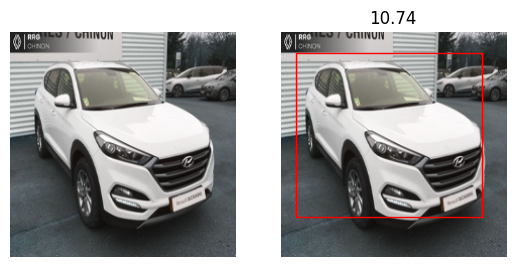

1/1 [==============================] - 0s 101ms/step
0.12953519821166992  seconds to predict bounding box.


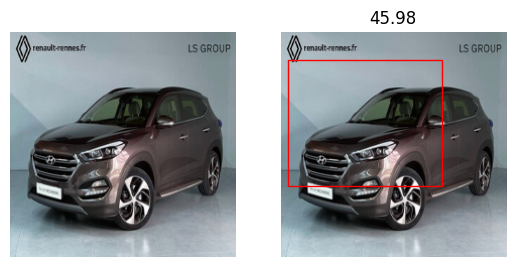

1/1 [==============================] - 0s 111ms/step
0.14243721961975098  seconds to predict bounding box.


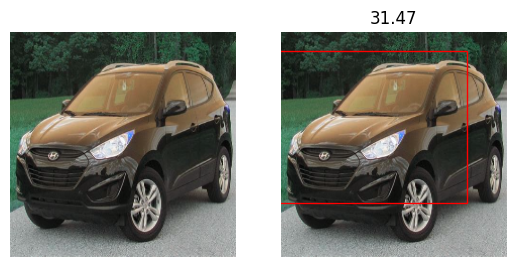

1/1 [==============================] - 0s 98ms/step
0.12384796142578125  seconds to predict bounding box.


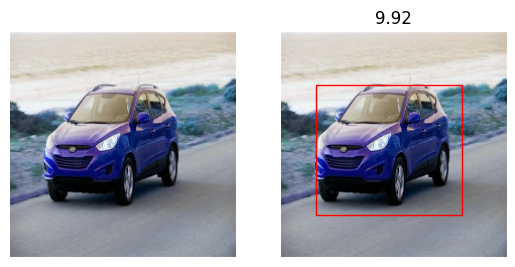

1/1 [==============================] - 0s 101ms/step
0.13580870628356934  seconds to predict bounding box.


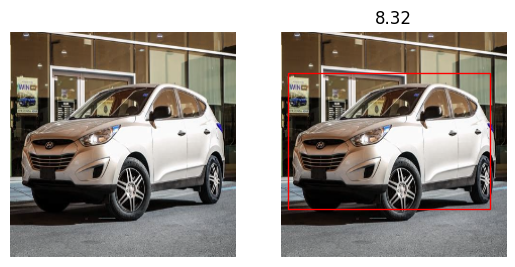

1/1 [==============================] - 0s 96ms/step
0.12446308135986328  seconds to predict bounding box.


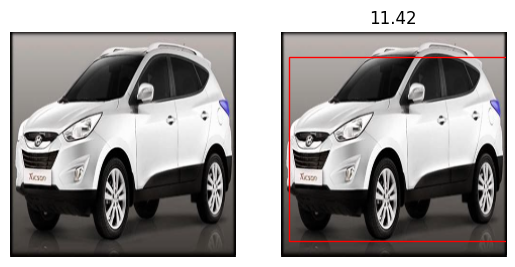

1/1 [==============================] - 0s 108ms/step
0.13581180572509766  seconds to predict bounding box.


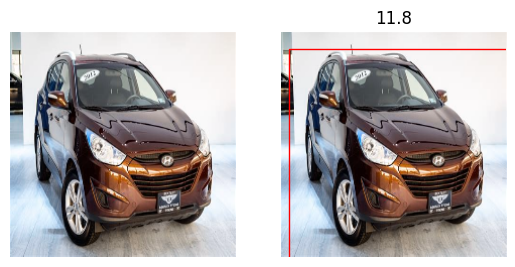

1/1 [==============================] - 0s 102ms/step
0.137115478515625  seconds to predict bounding box.


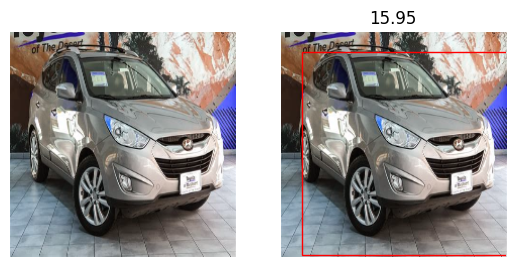

1/1 [==============================] - 0s 94ms/step
0.12029552459716797  seconds to predict bounding box.


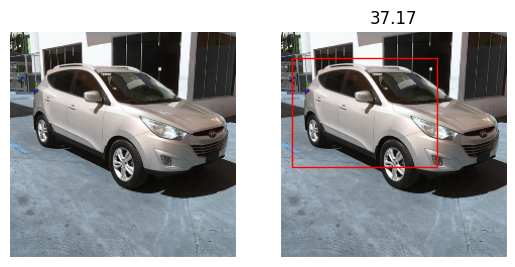

1/1 [==============================] - 0s 102ms/step
0.13407230377197266  seconds to predict bounding box.


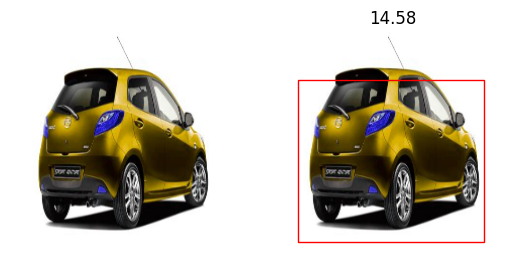

1/1 [==============================] - 0s 91ms/step
0.11720871925354004  seconds to predict bounding box.


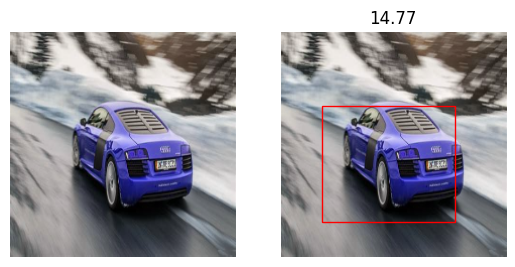

1/1 [==============================] - 0s 96ms/step
0.12204480171203613  seconds to predict bounding box.


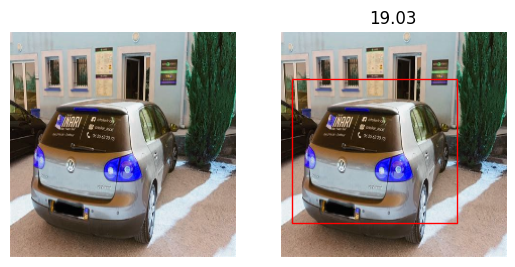

1/1 [==============================] - 0s 96ms/step
0.1233978271484375  seconds to predict bounding box.


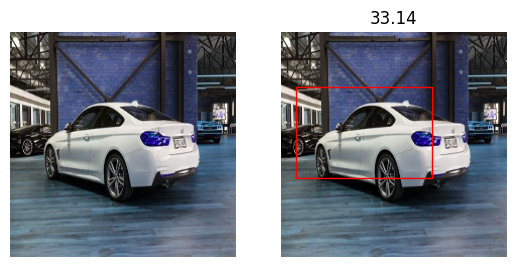

1/1 [==============================] - 0s 97ms/step
0.12554478645324707  seconds to predict bounding box.


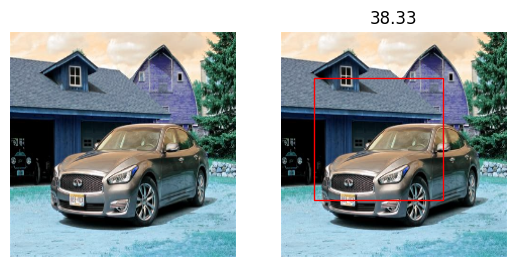

1/1 [==============================] - 0s 101ms/step
0.12786221504211426  seconds to predict bounding box.


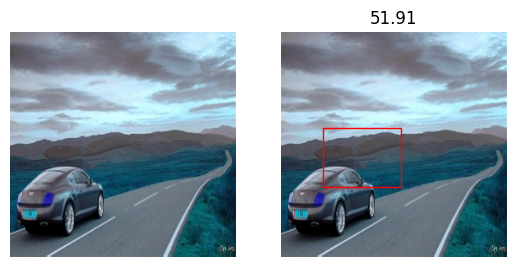

1/1 [==============================] - 0s 96ms/step
0.1237037181854248  seconds to predict bounding box.


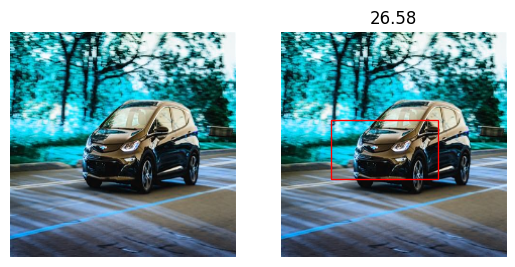

1/1 [==============================] - 0s 94ms/step
0.1202847957611084  seconds to predict bounding box.


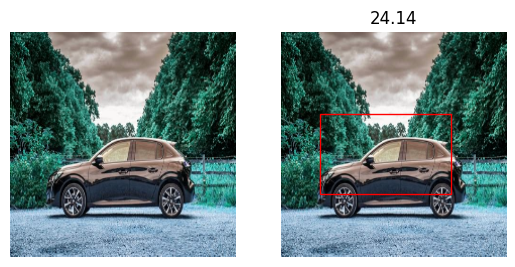

1/1 [==============================] - 0s 96ms/step
0.12227845191955566  seconds to predict bounding box.


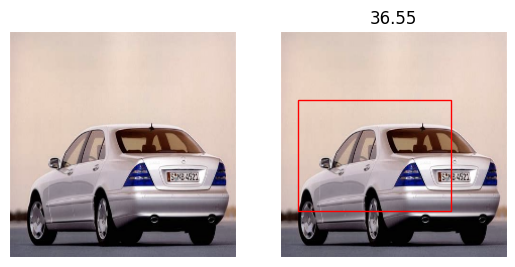

1/1 [==============================] - 0s 97ms/step
0.12424087524414062  seconds to predict bounding box.


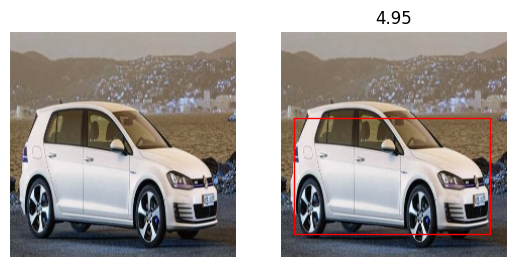

1/1 [==============================] - 0s 109ms/step
0.1385486125946045  seconds to predict bounding box.


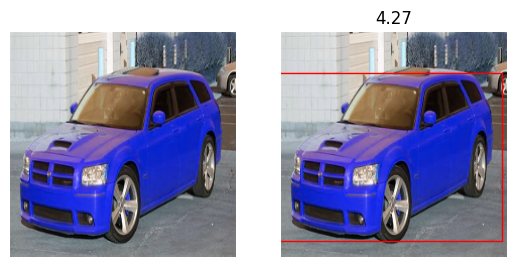

1/1 [==============================] - 0s 94ms/step
0.12370729446411133  seconds to predict bounding box.


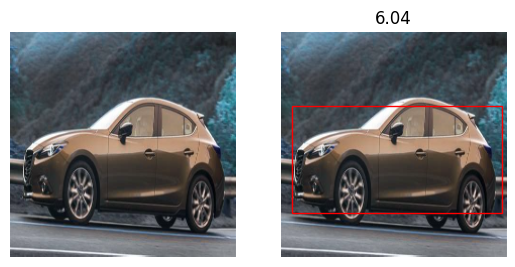

1/1 [==============================] - 0s 98ms/step
0.12270450592041016  seconds to predict bounding box.


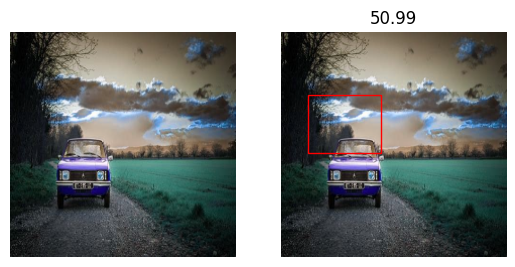

1/1 [==============================] - 0s 102ms/step
0.13884305953979492  seconds to predict bounding box.


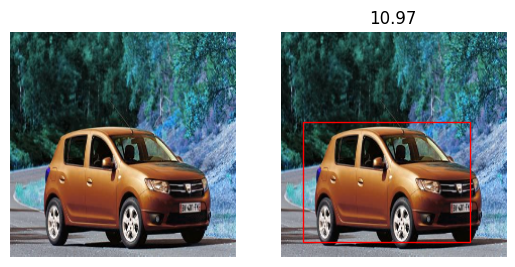

In [64]:
# Calculates the distance between two rectangles defined by their 4 corner points.
def rectangle_distance(rect1, rect2):
    # Calculate the midpoint of each rectangle
    rect1_midpoint = ((rect1[0] + rect1[2]) / 2, (rect1[1] + rect1[3]) / 2)
    rect2_midpoint = ((rect2[0] + rect2[2]) / 2, (rect2[1] + rect2[3]) / 2)

    # Calculate the distance between the midpoints
    distance = math.sqrt((rect1_midpoint[0] - rect2_midpoint[0])**2 + (rect1_midpoint[1] - rect2_midpoint[1])**2)

    return round(distance, 2)

# Display one image without and one image with bounding boxes.
def display_image(path, x1, y1, x2, y2, distance):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(path)
    ax[1].imshow(path)
    ax[1].set_title(distance)
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
    ax[0].axis("off")
    ax[1].axis("off")
    plt.show()


# Loop through the image filenames and process each image
for index in range(len(X_test)):
    start = time.time()
    image = np.expand_dims(X_test[index], axis=0)
    preds = model.predict(image)
    print(time.time() - start, " seconds to predict bounding box.")
    x1, y1, x2, y2 = preds.astype('int')[0]
    display_image(X_test[index], x1, y1, x2, y2, rectangle_distance(Y_test[index], (x1, y1, x2, y2)))
